# Graph Neural Networks

소셜 미디어 환경, 다양하게 이어져 있는 환경에서 유용한 데이터 구조가 있다. 바로 그래프 구조이다.

graph data , using library, visualization technique

In [3]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

/opt/conda/envs/deepface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# cora dataset

cora datset is a well known dataset in the field of graph research. this consist of 2708 scientific publications classifiied into one of seven classes

http://connectedpapers.com/


In [4]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

Processing...
Done!


In [5]:
print(f'Number of nodes: {data.num_nodes}')
# Number of nodes: 2708

Number of nodes: 2708


In [6]:
print(f'Number of edges: {data.num_edges}')
# Number of edges: 10556

Number of edges: 10556


In [7]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [20]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
print(edge_index)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
print(edge_example)
edge_example.shape

(2, 10556)
[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]
[[  30   30   30   30   30   30]
 [ 697  738 1358 1416 2162 2343]]


(2, 6)

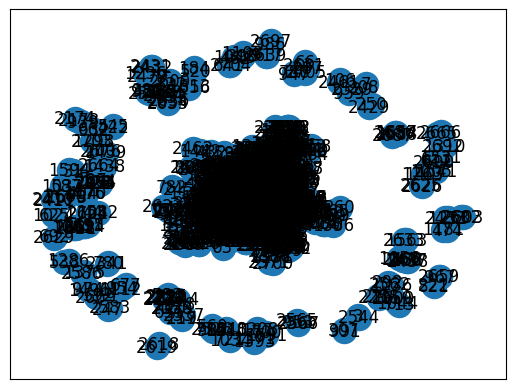

In [16]:
# let's try to draw a net work centered on this node 

# unique node. 0 ~ 2707
node_example = np.unique(edge_index.flatten()) 

G = nx.Graph()
G.add_nodes_from(node_example) # add node
G.add_edges_from(list(zip(edge_index[0],edge_index[1])))

nx.draw_networkx(G,with_labels=True)


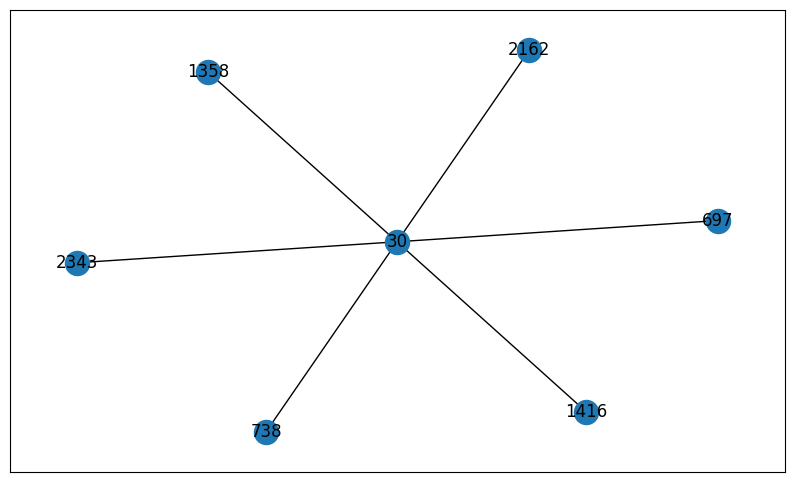

In [22]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))

G = nx.Graph()
G.add_nodes_from(node_example) # add node
G.add_edges_from(list(zip(edge_example[0],edge_example[1])))

nx.draw_networkx(G,with_labels=True)

In [23]:
xx = list(zip(edge_example[0],edge_example[1]))
print(xx)

[(30, 697), (30, 738), (30, 1358), (30, 1416), (30, 2162), (30, 2343)]

In [26]:
# node degree 

# degree in graph theory means the number of edges joining a vertex(node)
# in a graph. we saw earlier that each node always has an edge, so how many edges does each node have on aaverage?

print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90



Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


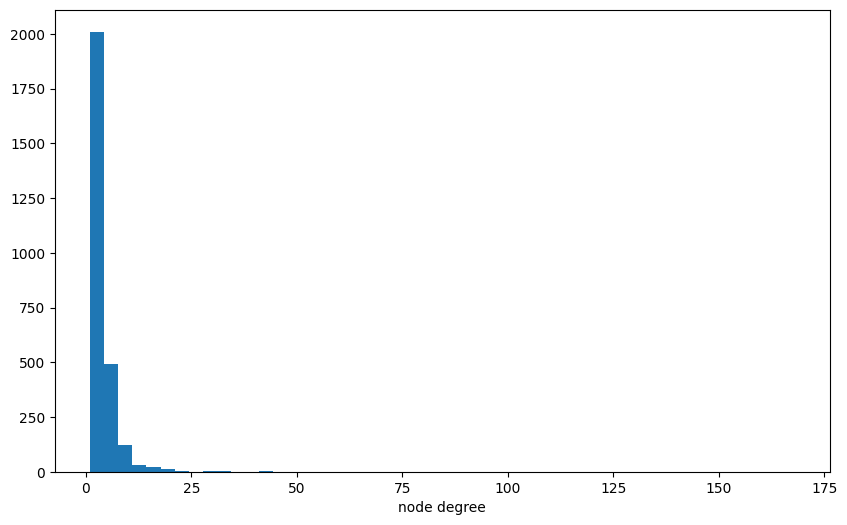

In [27]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

In [45]:
G = to_networkx(data,to_undirected = True)
pos = nx.spring_layout(G,seed = 42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x : x *500, cent.values()))

cent_array = np.array(list(cent.values()))


threshold 0.011821204285186553


/opt/conda/envs/deepface/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


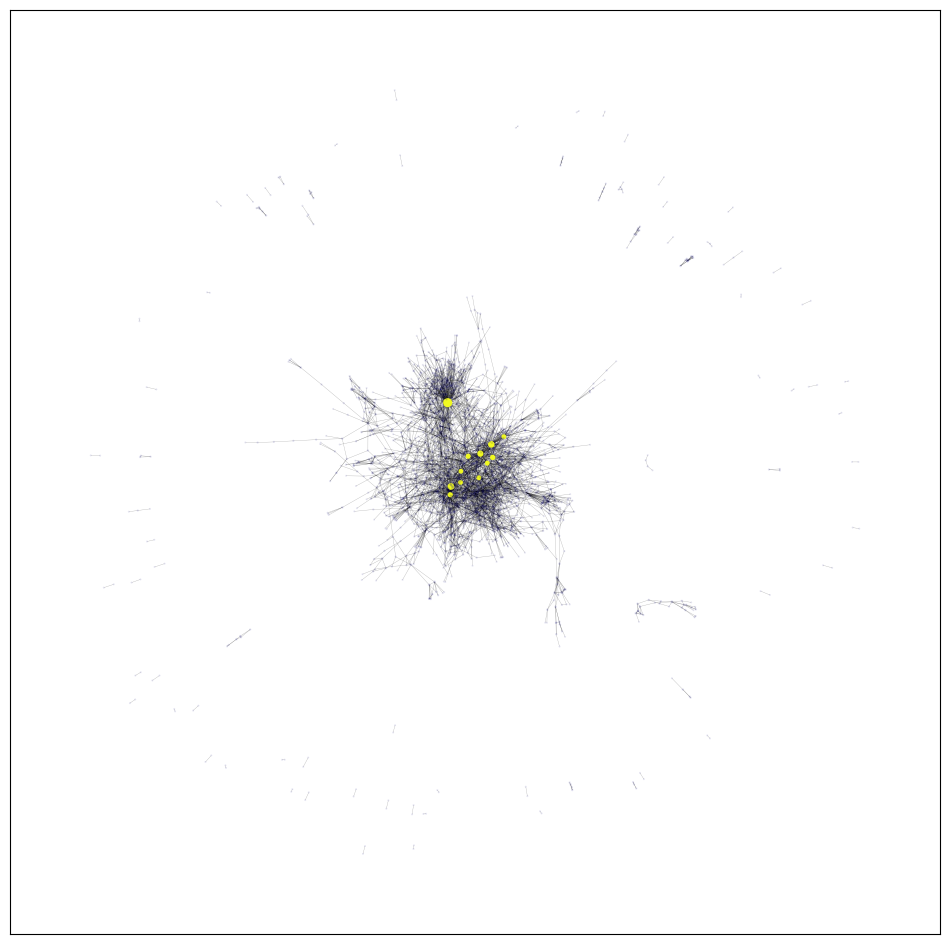

In [28]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))

cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [34]:
print(f'Number of features: {data.num_node_features}')
# Number of edge features: 0

print(len(data.x[0]))
print(data.x[0].shape)
data.x[0][:10]

Number of features: 1433
1433
torch.Size([1433])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
print(f'number of edge features : {data.num_edge_features}')
# number of edge features : 0

number of edge features : 0


In [36]:
# classes 
print(f'number of classes : {dataset.num_classes}')
# number of classes : 7

number of classes : 7


In [42]:
xx = data.y.numpy()

xxx = np.unique(xx.flatten()) 
xxx

array([0, 1, 2, 3, 4, 5, 6])

In [37]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10] # 0~6

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


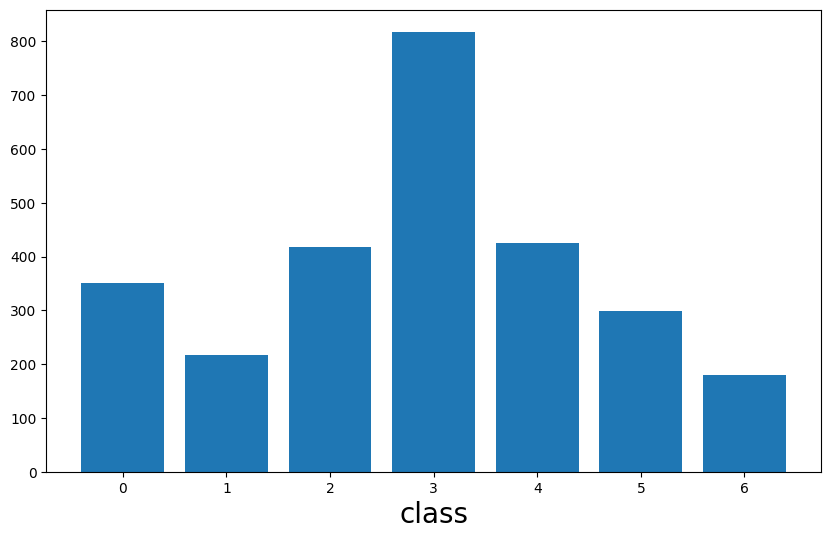

In [43]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

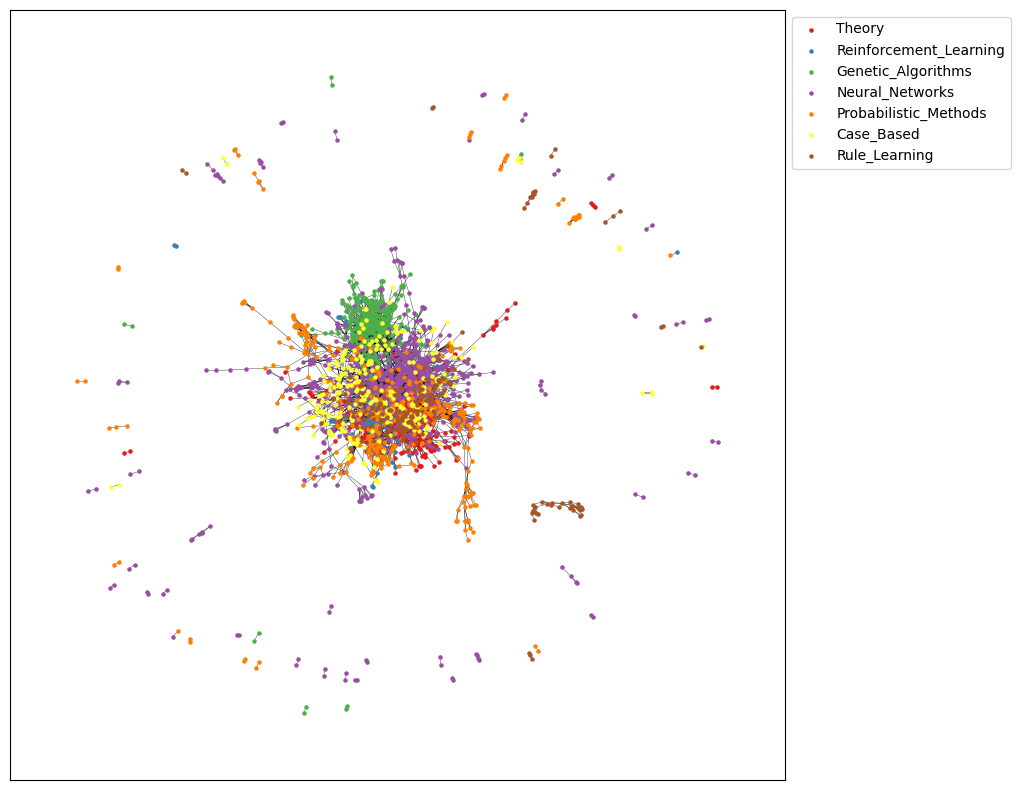

In [44]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Homophily

node with the same characteristics are often connected. this property is called homophily. for the seven classes we looked at earlier, we will se how many nodes of the same class are connected by deges an vice versa.


In [55]:
data.edge_index.shape , data.edge_index

(torch.Size([2, 10556]),
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]))

In [88]:
# labels[0], data.edge_index.numpy()[0] -> int, array :10000

In [66]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))

print(labels.shape) # node
print(data.edge_index) # edges 
print(connected_labels_set[0][12812:12834])


(2708,)
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
[]


label: 0
1527 edges
{0: 1068, 1: 32, 3: 161, 6: 80, 5: 75, 4: 88, 2: 23}
label: 1
1029 edges
{1: 818, 3: 67, 0: 32, 5: 28, 2: 62, 4: 20, 6: 2}
label: 2
1826 edges
{2: 1654, 3: 53, 1: 62, 5: 30, 0: 23, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 2: 53, 4: 137, 5: 54, 0: 161, 6: 16, 1: 67}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{2: 30, 5: 834, 0: 75, 3: 54, 1: 28, 4: 19, 6: 46}
label: 6
658 edges
{6: 506, 5: 46, 0: 80, 4: 6, 3: 16, 1: 2, 2: 2}


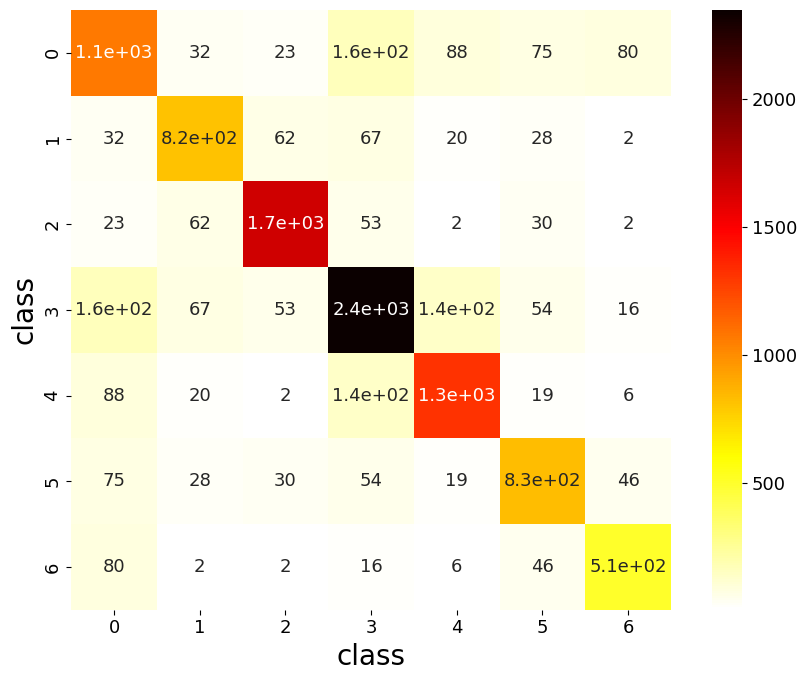

In [89]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()


In [90]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()
# 0.8099658961727927

0.8099658961727927

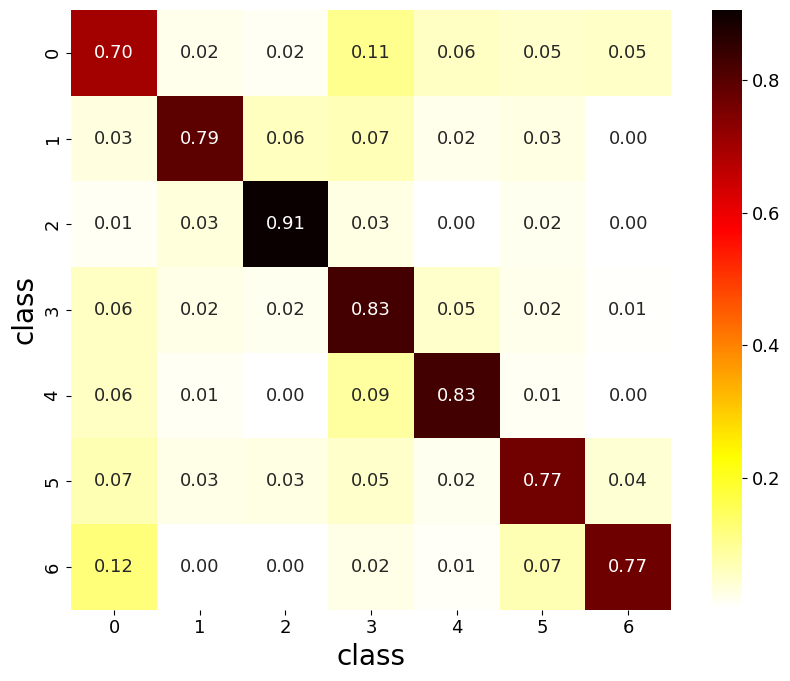

In [91]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [92]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


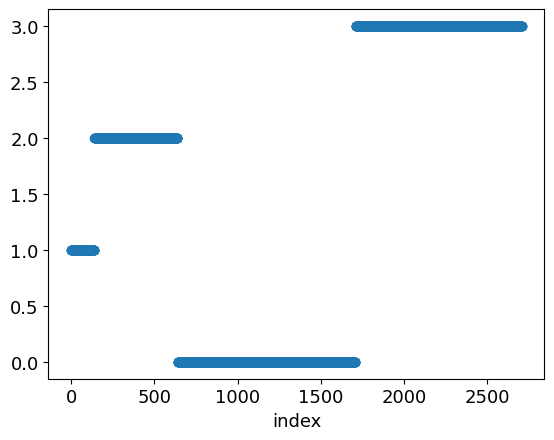

In [93]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
plt.scatter(range(2708), split_type_array)
plt.xlabel("index")
plt.show()

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


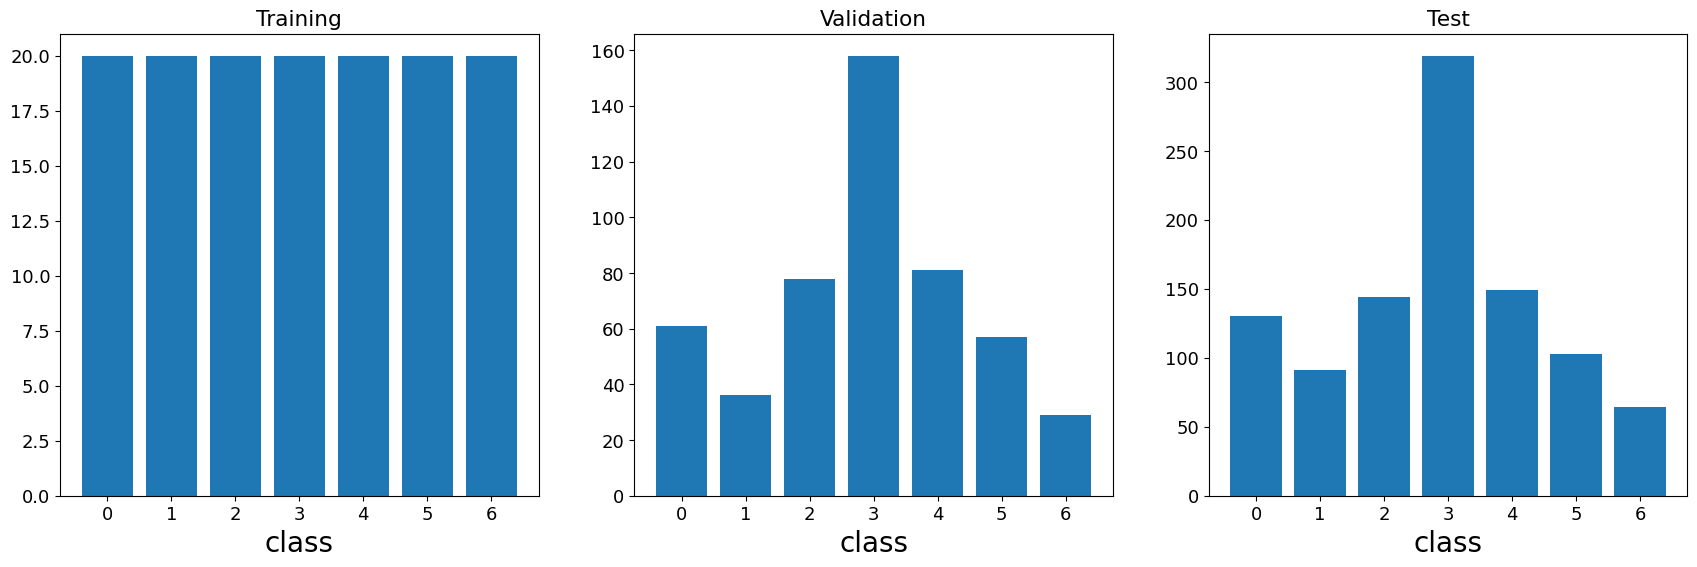

In [96]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
    # plt.figure(figsize=(10, 6))
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()